In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/instquality/")

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

# load

df = pd.read_pickle("saved/merged.dat")

# drop redundant cols

from functions.labels import *

label_dicts = {
    "tgt": tgt_labels,
    "fiw": fiw_labels,
    "ief": ief_labels,
    "efw": efw_labels,
    "pts": pts_labels,
    "p5d": p5d_labels,
    "wb_iq": wb_iq_labels,
    "wgi": wgi_labels,
    "controls": controls_labels,
}

keep_cols = ['country', 'year', 'iso_code_1','iso_code_2', 'region'] + [v for d in label_dicts.values() for v in d.keys()]
dropped = [c for c in df.columns if c not in keep_cols]
df = df[[c for c in df.columns if c in keep_cols]].copy()
print(f"Kept {len(df.columns)} cols, dropped {len(dropped)}")

Kept 136 cols, dropped 83


In [ ]:
# create lagged target var, drop other target vars

from functions.utils import prep_target

df = prep_target(df)

# drop countries without target data

b_obs, b_cty = len(df), df["country"].nunique()
valid_countries = df.groupby('country')['tgt_spread'].transform(lambda x: x.notna().any())
df = df[valid_countries].copy().reset_index(drop=True)
a_obs, a_cty = len(df), df["country"].nunique()

print(f"Kept {a_cty} countries, dropped {b_cty - a_cty}\nKept {a_obs:,} obs, dropped {(b_obs - a_obs):,}")

Kept 71 countries, dropped 127
Kept 4,605 obs, dropped 7,933


Median year for 75% coverage: 2016


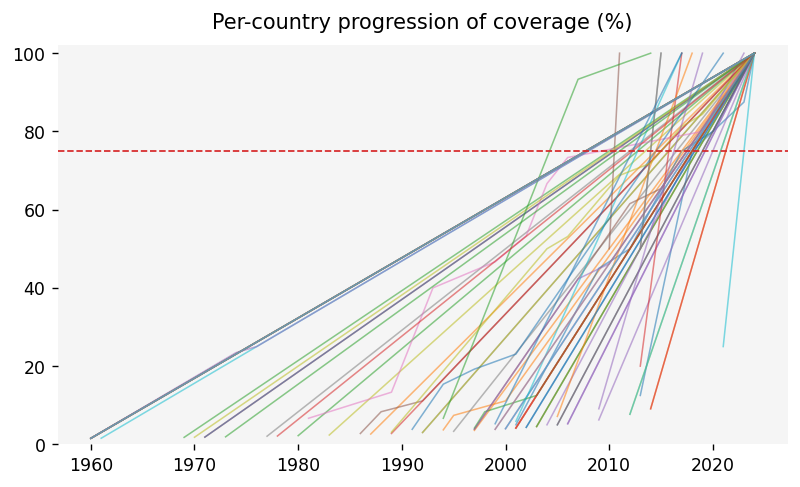

In [ ]:
# identify split year as year when countries have c. 75% behind them

yname = "tgt_spread"

dff = df.dropna(subset=[yname]).sort_values(["country", "year"])
dff["cum_share"] = (dff.groupby("country").cumcount() + 1) / dff.groupby("country")["year"].transform("count")
cross_years = dff.loc[dff["cum_share"] >= 0.75].groupby("country")["year"].min()
print(f"Median year for 75% coverage: {int(cross_years.median())}")

from functions.plot import coverage_progression

coverage_progression(df)

In [ ]:
# forward-fill

from functions.fill import fill

df_ff = fill(df)

# remove stale observations (fills from 3+ years)

fcols = [c for c in df_ff.columns if c.endswith("_f") and c != "fiw_f"]
ffilled_count = 0
removed_count = 0

for fcol in fcols:
    base = fcol[:-2]
    if base in df_ff.columns:
        m_ffilled = (df_ff[fcol] > 0) & (df_ff[fcol] <= 3) & df_ff[base].notna()
        m_removed = (df_ff[fcol] > 3) & df_ff[base].notna()
        ffilled_count += m_ffilled.sum()
        removed_count += m_removed.sum()
        df_ff.loc[df_ff[fcol] > 3, base] = np.nan

# fills summary

print(f"\n{removed_count:,} f-filled values removed due to staleness (3+ years), {ffilled_count:,} f-filled values remain")

from functions.fill import save_nulls_share

df_ff = save_nulls_share(df_ff, 'ffill')
print(f"Average observation null share decreased from {df_ff["nulls_init"].mean()*100:.0f} to {df_ff["nulls_ffill"].mean()*100:.0f} percent")
df_ff = df_ff.drop(columns=["nulls_init", "nulls_ffill"])

# drop _f metadata cols for further processing

assert(df_ff.tgt_spread.notnull().sum()==df.tgt_spread.notnull().sum())
fcols = [c for c in df_ff.columns if c.endswith("_f") and c != "fiw_f"]
df = df_ff.drop(columns=fcols)

F-filling Angola values
F-filling Armenia values
F-filling Australia values
F-filling Austria values
F-filling Bangladesh values
F-filling Belgium values
F-filling Botswana values
F-filling Brazil values
F-filling Bulgaria values
F-filling Canada values
F-filling Chile values
F-filling China values
F-filling Colombia values
F-filling Costa Rica values
F-filling Croatia values
F-filling Cyprus values
F-filling Czechia values
F-filling Côte d'Ivoire values
F-filling Denmark values
F-filling Estonia values
F-filling Fiji values
F-filling Finland values
F-filling France values
F-filling Germany values
F-filling Ghana values
F-filling Greece values
F-filling Hungary values
F-filling Iceland values
F-filling India values
F-filling Indonesia values
F-filling Ireland values
F-filling Israel values
F-filling Italy values
F-filling Japan values
F-filling Kyrgyzstan values
F-filling Latvia values
F-filling Lithuania values
F-filling Luxembourg values
F-filling Malaysia values
F-filling Malta valu

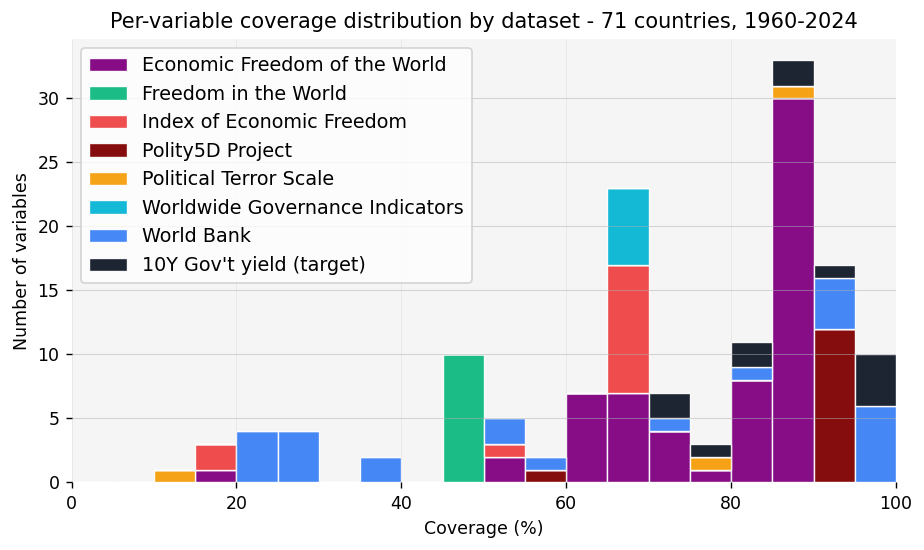

Removed 14 columns with less than 40% coverage, 278 remain
Removed ['efw_5diii_distorton_of_the_business_environment', 'ief_judicial_effectiveness', 'ief_fiscal_health', 'pts_pts_h', 'wb_iq_sci_mthd', 'wb_iq_sci_ovrl', 'wb_iq_sci_prdc', 'wb_iq_sci_srce', 'wb_iq_spi_ovrl', 'wb_iq_spi_pil2', 'wb_iq_spi_pil4', 'wb_iq_spi_pil5', 'wb_iq_wef_cust_xq', 'wb_iq_wef_port_xq']


In [ ]:
# show columns coverage

from functions.plot import coverage_per_variable

likely_df = df[df.tgt_spread_t1.notna()]
coverage_per_variable(likely_df)

# drop columns with less than 40% coverage

coverage = likely_df.notna().mean()
to_drop = coverage[coverage < 0.4].index
df = df.drop(columns=to_drop)
print(f"Removed {len(to_drop)} columns with less than 40% coverage, {df_ff.shape[1]} remain")
print("Removed", to_drop.tolist() )

In [ ]:
# drop near identical columns

from functions.utils import remove_highly_correlated

shape_before = df.shape
cols_to_drop = remove_highly_correlated(df, threshold=0.99)
df = df.drop(columns=cols_to_drop)
print(f"Core variables dropped: {cols_to_drop}")
print(f"Number of core variables dropped: {len(cols_to_drop)}")
print(f"Original shape: {shape_before}")
print(f"New shape: {df.shape}")

Core variables dropped: ['fiw_total', 'p5d_exconst', 'p5d_exrec', 'p5d_parcomp', 'p5d_parreg', 'p5d_polcomp', 'p5d_xrcomp', 'p5d_xropen']
Number of core variables dropped: 8
Original shape: (4605, 133)
New shape: (4605, 125)


In [ ]:
# create engineered variables for macro and IQ

from functions.utils import engineer_lag_vars

id_cols = ["country", "year", "iso_code_1", "iso_code_2", "region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_vars = [c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude]
iq_vars = [c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))]

df = engineer_lag_vars(df, macro_vars, iq_vars)

# save dataset

df.to_pickle("saved/df.dat")

Added 864 engineered columns
